<a href="https://colab.research.google.com/github/hereagain-Y/TF_tutorial/blob/main/VAE_add_Validationv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from six.moves import xrange

Load CDR3 Data

In [2]:
s = []
my_file = open("/content/drive/My Drive/DL/VAE/NormalCDR3.txt", "r")
content_list = my_file.read().splitlines()
content_list=np.array(content_list)
print(content_list)


['CASSLKPNTEAFF' 'CASSAHIANYGYTF' 'CASSPRPNTEAFF' ... 'CASSVDVGYEQYF'
 'CASRLAGQETQYF' 'CASSVVPNTEAFF']


Load AA index data

In [ ]:
d= {} # bipphysics dictionary
with open("/content/drive/My Drive/DL/VAE/AAidx_PCA.txt") as f:
    next(f)
    for line in f.readlines():
        line=line.strip().split('\t') #
        AA=line[0]
        tag=0
        values=[]
        for PC in line[1:]:
            values.append(float(PC))
        if tag==1: 
            continue
        d[AA]=values
d # AA


In [73]:
# max length
#comp_seq=data["amino_acid"].tolist()

comp_seq=content_list
print(comp_seq)
max_len=-1 

for AA in comp_seq:
    if len(AA)>max_len:
        max_len=len(AA)
        #res=AA
print(max_len )

['CASSLKPNTEAFF' 'CASSAHIANYGYTF' 'CASSPRPNTEAFF' ... 'CASSVDVGYEQYF'
 'CASRLAGQETQYF' 'CASSVVPNTEAFF']
19


In [5]:
PC_length=len(d['C'])
def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global max_len
    AAE=np.zeros([max_len,15])
    if length_seq<max_len:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d[AA] # add PC value 
            
        for amino in range(length_seq,max_len):
            AAE[amino,]=np.zeros(15)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 
  
def GetFeatures(file):
    #sequence=file['amino_acid'].tolist()
    #sequence=np.array(sequence)
    #sequence = file.read().splitlines()
    #sequence=np.array(sequence)
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result) # dimension: number of sequence [15*length(sequence)]


r1=GetFeatures(content_list)

In [ ]:
r1[1]

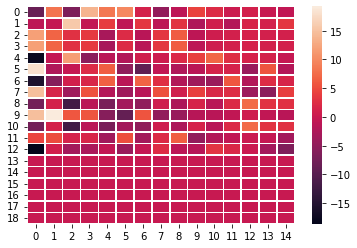

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [103]:
# transform 
kwargs = {'num_workers': 1, 'pin_memory': True} 
r1_transform=torch.from_numpy(r1) # from np to tensor
r1_transform=r1_transform.float()
r1_transform.shape
r1_mean = torch.mean(r1_transform)
r1_std = torch.std(r1_transform)
r1_var =  torch.var(r1_transform)
print("mean, std, var of tensor:\n", r1_mean, r1_std, r1_var)

# normalization 
r1_transform = (r1_transform-r1_mean)/r1_var
#train_ds, test_ds = torch.utils.data.random_split(r2_transform, (30000, 10000))
train_ds, test_ds =torch.utils.data.random_split(r1_transform, (int(0.8*len(r1_transform)), len(r1_transform)-int(0.8*len(r1_transform))))
print(train_ds, test_ds)

train_loader = DataLoader(dataset=train_ds, batch_size=1000)
test_loader  = DataLoader(dataset=test_ds,  batch_size=1000)



mean, std, var of tensor:
 tensor(0.4809) tensor(4.6476) tensor(21.5999)
<torch.utils.data.dataset.Subset object at 0x7f39d8181e50> <torch.utils.data.dataset.Subset object at 0x7f39d8181f90>


In [86]:
r2_transform.shape

torch.Size([29695, 19, 15])

In [104]:
# set paramters:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 1000

x_dim=285 # 19*15
hidden_dim = 256
hidden_dim2 = 128

latent_dim = 64

lr = 1e-3

epochs = 100

In [105]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim,hidden_dim2, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim2)
        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        h_       = self.LeakyReLU(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [106]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim,hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden3(h))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [108]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [109]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2,output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [110]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [111]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    train_loss= []
    testtoal_loss= []
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        train_loss.append(loss.item())
        
        loss.backward()
       
        optimizer.step()
      #test loss
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        #optimizer.zero_grad()

        pred, mean, log_var = model(x)
        test_loss = loss_function(x, pred, mean, log_var)
        overall_testloss += test_loss.item()
        testtoal_loss.append(test_loss.item())

        
        
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size),
         "\tAverage Test Loss: " , overall_testloss/(batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  -406.868013671875 	Average Test Loss:  -614.7201875
	Epoch 2 complete! 	Average Loss:  -2700.449410714286 	Average Test Loss:  -768.9689017857143
	Epoch 3 complete! 	Average Loss:  -3015.9175892857143 	Average Test Loss:  -779.0151785714286
	Epoch 4 complete! 	Average Loss:  -3021.0323392857144 	Average Test Loss:  -753.3643392857143
	Epoch 5 complete! 	Average Loss:  -2880.82175 	Average Test Loss:  -727.2571160714285
	Epoch 6 complete! 	Average Loss:  -2992.5082410714285 	Average Test Loss:  -799.4493214285715
	Epoch 7 complete! 	Average Loss:  -3185.2891964285714 	Average Test Loss:  -793.7191875
	Epoch 8 complete! 	Average Loss:  -3192.4575 	Average Test Loss:  -799.2377053571429
	Epoch 9 complete! 	Average Loss:  -3174.3130089285714 	Average Test Loss:  -786.6026517857143
	Epoch 10 complete! 	Average Loss:  -3170.3779910714284 	Average Test Loss:  -800.7993839285714
	Epoch 11 complete! 	Average Loss:  -3230.6246964285715 	Av

In [112]:


#save model
torch.save(model, '/content/drive/My Drive/DL/VAE/VAE_modify_model_2000_echo.apx')

model = torch.load('/content/drive/My Drive/DL/VAE/VAE_modify_model_2000_echo.apx')

In [113]:
# load model. 

my_file2 = open("/content/drive/My Drive/DL/VAE/TumorCDR3.txt", "r")
content_list2 = my_file2.read().splitlines()

#content_list2=np.array(content_list2)

neww=[x for x in content_list2 if len(x)<=19]


neww=np.array(neww)


r2=GetFeatures(neww)

r2.shape

(29695, 19, 15)

In [122]:
r2_transform=torch.from_numpy(r2) # from np to tensor
r2_transform=r2_transform.float().cuda()
r2_mean = torch.mean(r2_transform)
r2_std = torch.std(r2_transform)
r2_var =  torch.var(r2_transform)


# normalization 
r2_transform = (r2_transform-r2_mean)/r2_var
r2_transform.shape
#result = model(r2_transform)
m2 = r2_transform.view(len(r2_transform), 285)
result = model(m2)[0]

result2=result.cpu().view( len(result),19,15 ).detach().numpy()


In [126]:
result2.shape

(29695, 19, 15)

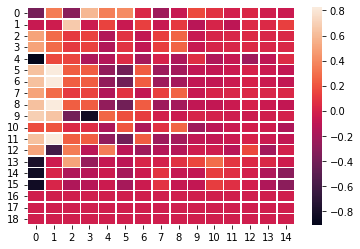

In [125]:
# show. figure 
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

fig1 = r2_transform.cpu()[5] # move to cpu first 
ax = sns.heatmap(fig1, linewidth=0.5)
plt.show()



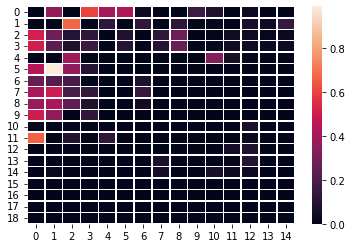

In [127]:
# for result data
fig2 = result2[5] # move to cpu first 
ax = sns.heatmap(fig2, linewidth=0.5)
plt.show()